In [25]:
import pandas as pd 
import numpy as np
import yfinance as yf
import seaborn as sns 
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
import warnings

In [26]:
plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
# plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
STOCK = "PYPL"
START = "2018-01-01"
END = "2021-01-04"

stock_df = yf.download(STOCK, 
                      start=START, 
                      end=END, 
                      progress=True)
stock_df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,74.235001,74.500000,73.430000,73.839996,73.839996,7296500
2018-01-03,74.300003,76.849998,74.050003,76.750000,76.750000,9945400
2018-01-04,77.330002,77.929001,76.260002,76.730003,76.730003,8650000
2018-01-05,77.110001,78.930000,77.010002,78.699997,78.699997,11822100
2018-01-08,78.699997,79.180000,77.773003,79.050003,79.050003,7963600


In [17]:
stock_close = stock_df.loc[:, ['Adj Close']]
stock_close.rename(columns={'Adj Close':'adj_close'}, inplace=True)

In [18]:
stock_close['log_return'] = np.log(stock_close['adj_close']/stock_close['adj_close'].shift())

In [19]:
r_range = np.linspace(min(stock_close.log_return), max(stock_close.log_return), num=1000)
mu = stock_close.log_return.mean()
sigma = stock_close.log_return.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma) 

Text(0.5, 1.0, 'Q-Q plot')

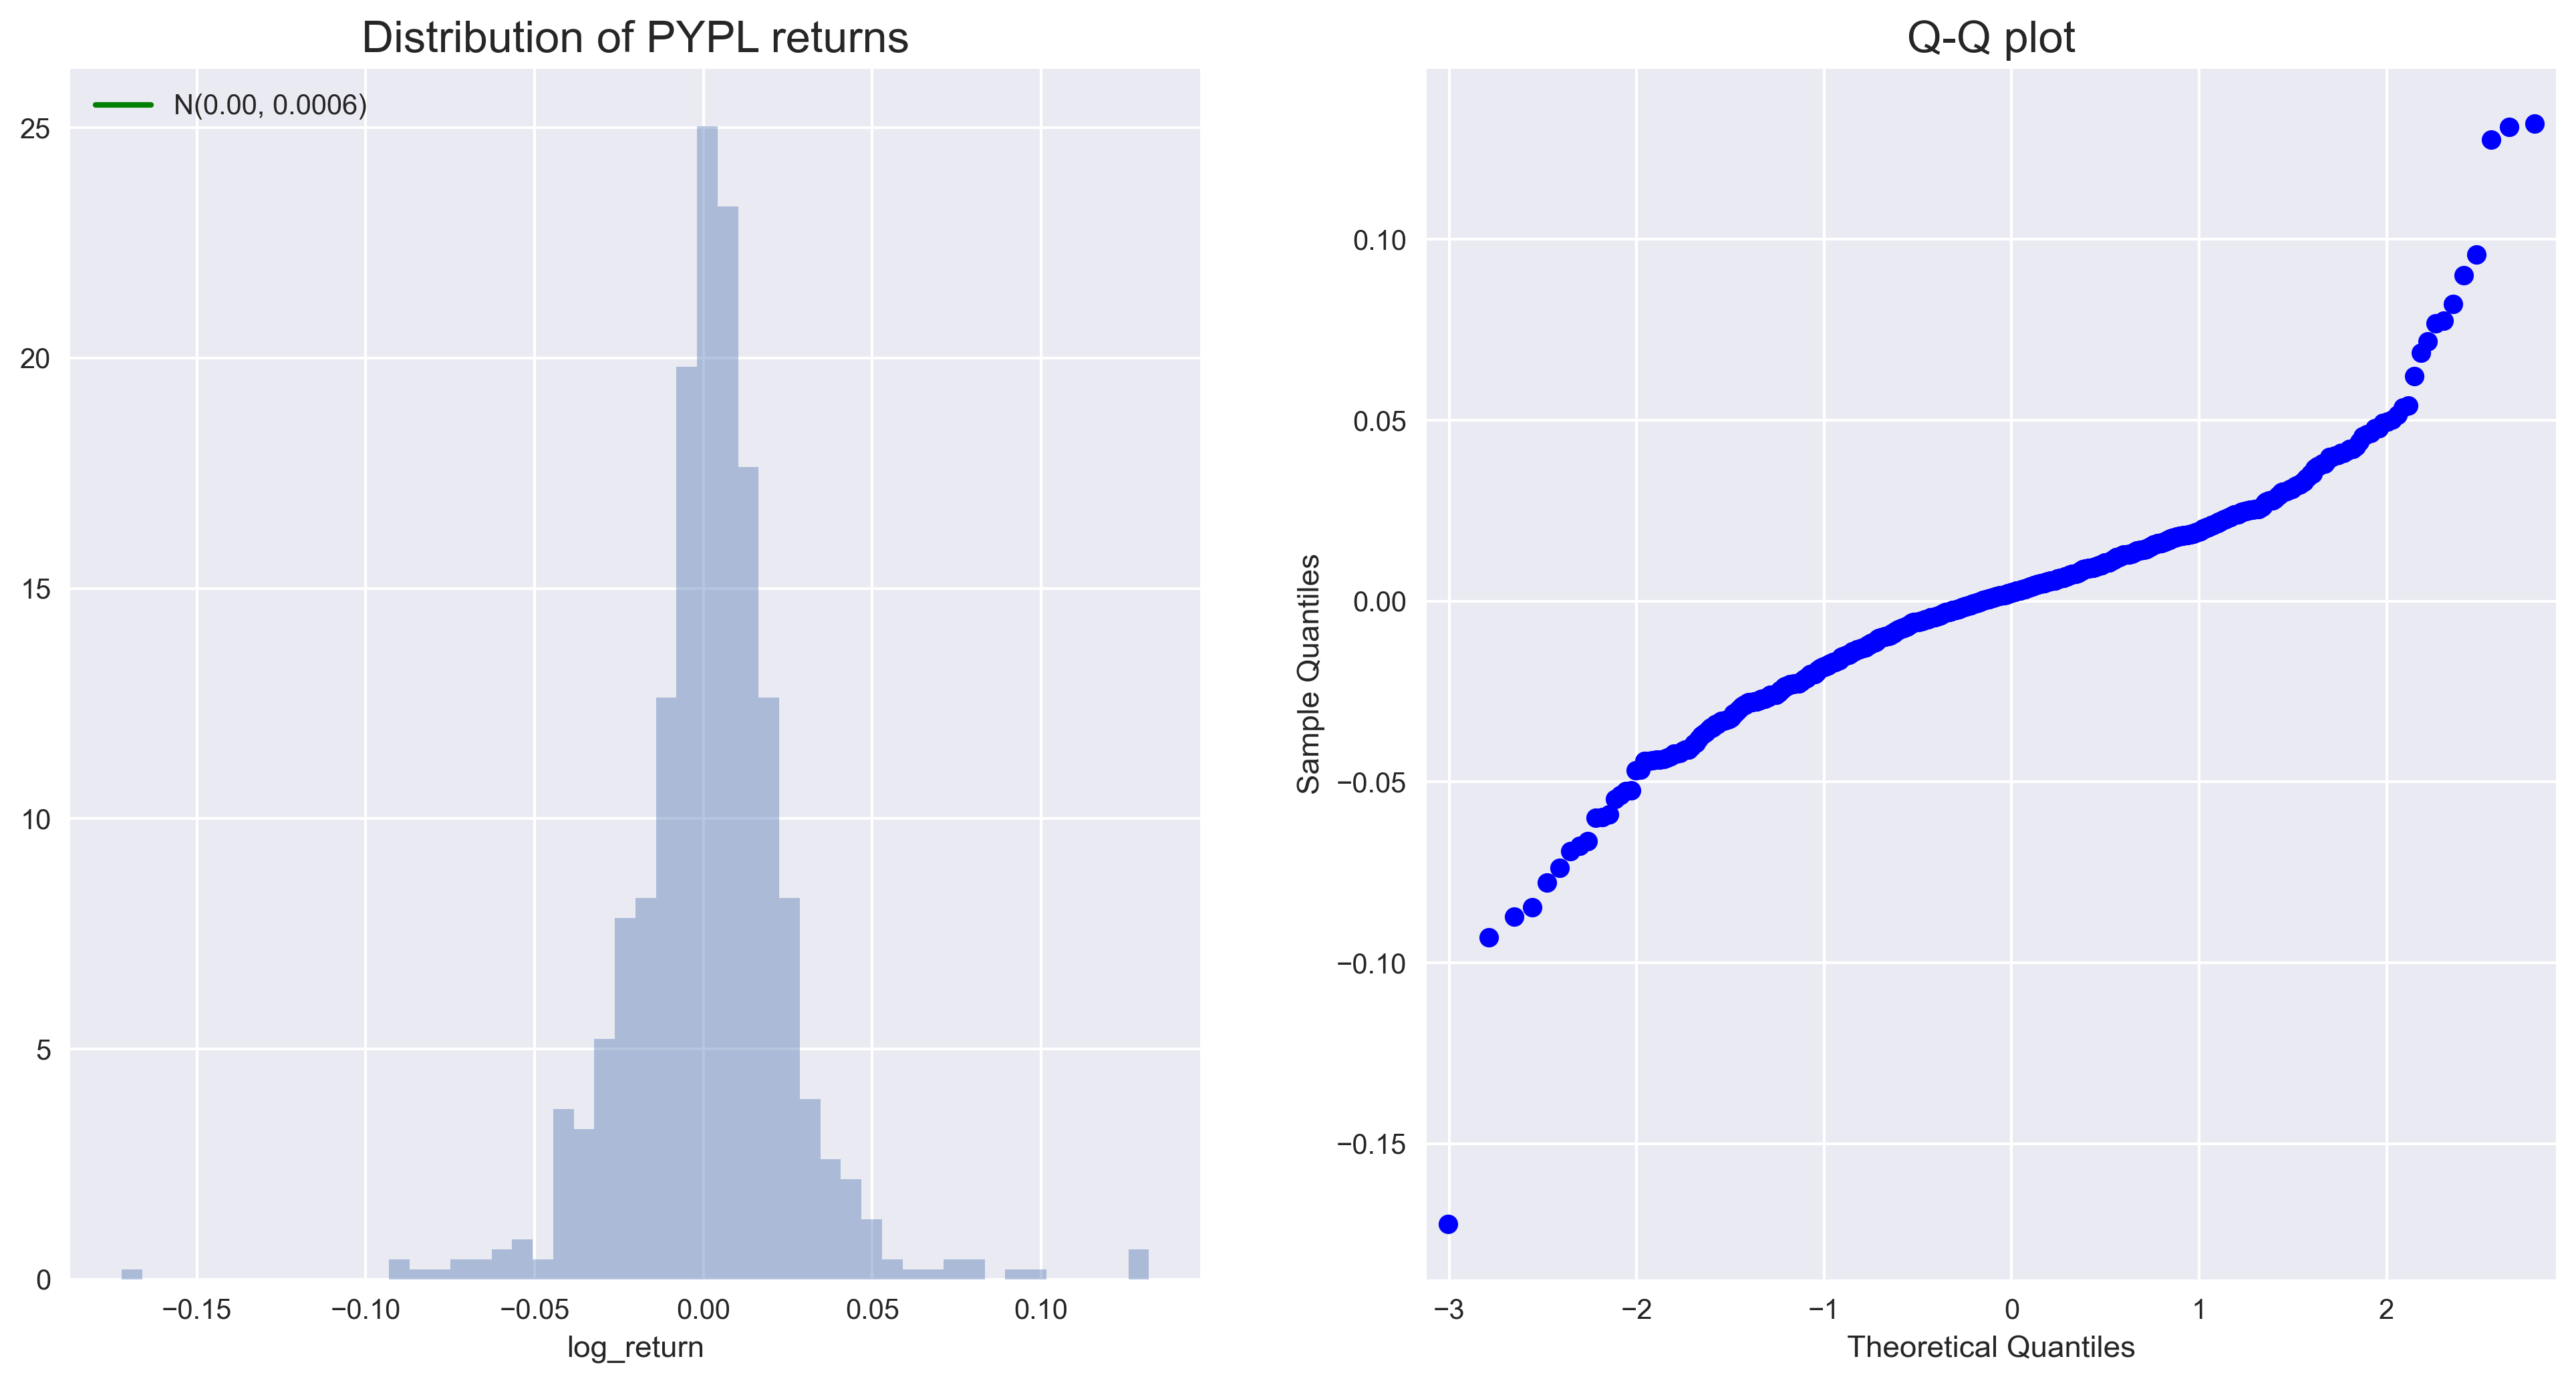

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# histogram
sns.distplot(stock_close.log_return, kde=False, norm_hist=True, ax=ax[0]) 
ax[0].set_title(f'Distribution of {STOCK} returns', fontsize=16) 
ax[0].plot(r_range, norm_pdf, 'g', lw=2, 
           label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left');

# Q-Q plot
qq = sm.qqplot(stock_close.log_return.values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)

In [30]:
jb_test = scs.jarque_bera(stock_close.log_return.values)

print('---------- Descriptive Statistics ----------')
print('Range of dates:', min(stock_close.index.date), '-', max(stock_close.index.date))
print('Number of observations:', stock_close.shape[0])
print(f'Mean: {stock_close.log_return.mean():.4f}')
print(f'Median: {stock_close.log_return.median():.4f}')
print(f'Min: {stock_close.log_return.min():.4f}')
print(f'Max: {stock_close.log_return.max():.4f}')
print(f'Standard Deviation: {stock_close.log_return.std():.4f}')
print(f'Skewness: {stock_close.log_return.skew():.4f}')
print(f'Kurtosis: {stock_close.log_return.kurtosis():.4f}') 
print(f'Jarque-Bera statistic: {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}')

---------- Descriptive Statistics ----------
Range of dates: 2018-01-02 - 2020-12-31
Number of observations: 756
Mean: 0.0015
Median: 0.0024
Min: -0.1723
Max: 0.1320
Standard Deviation: 0.0245
Skewness: -0.0676
Kurtosis: 7.1803
Jarque-Bera statistic: nan with p-value: nan


## Volatility

<AxesSubplot:title={'center':'Daily PYPL returns'}, xlabel='Date'>

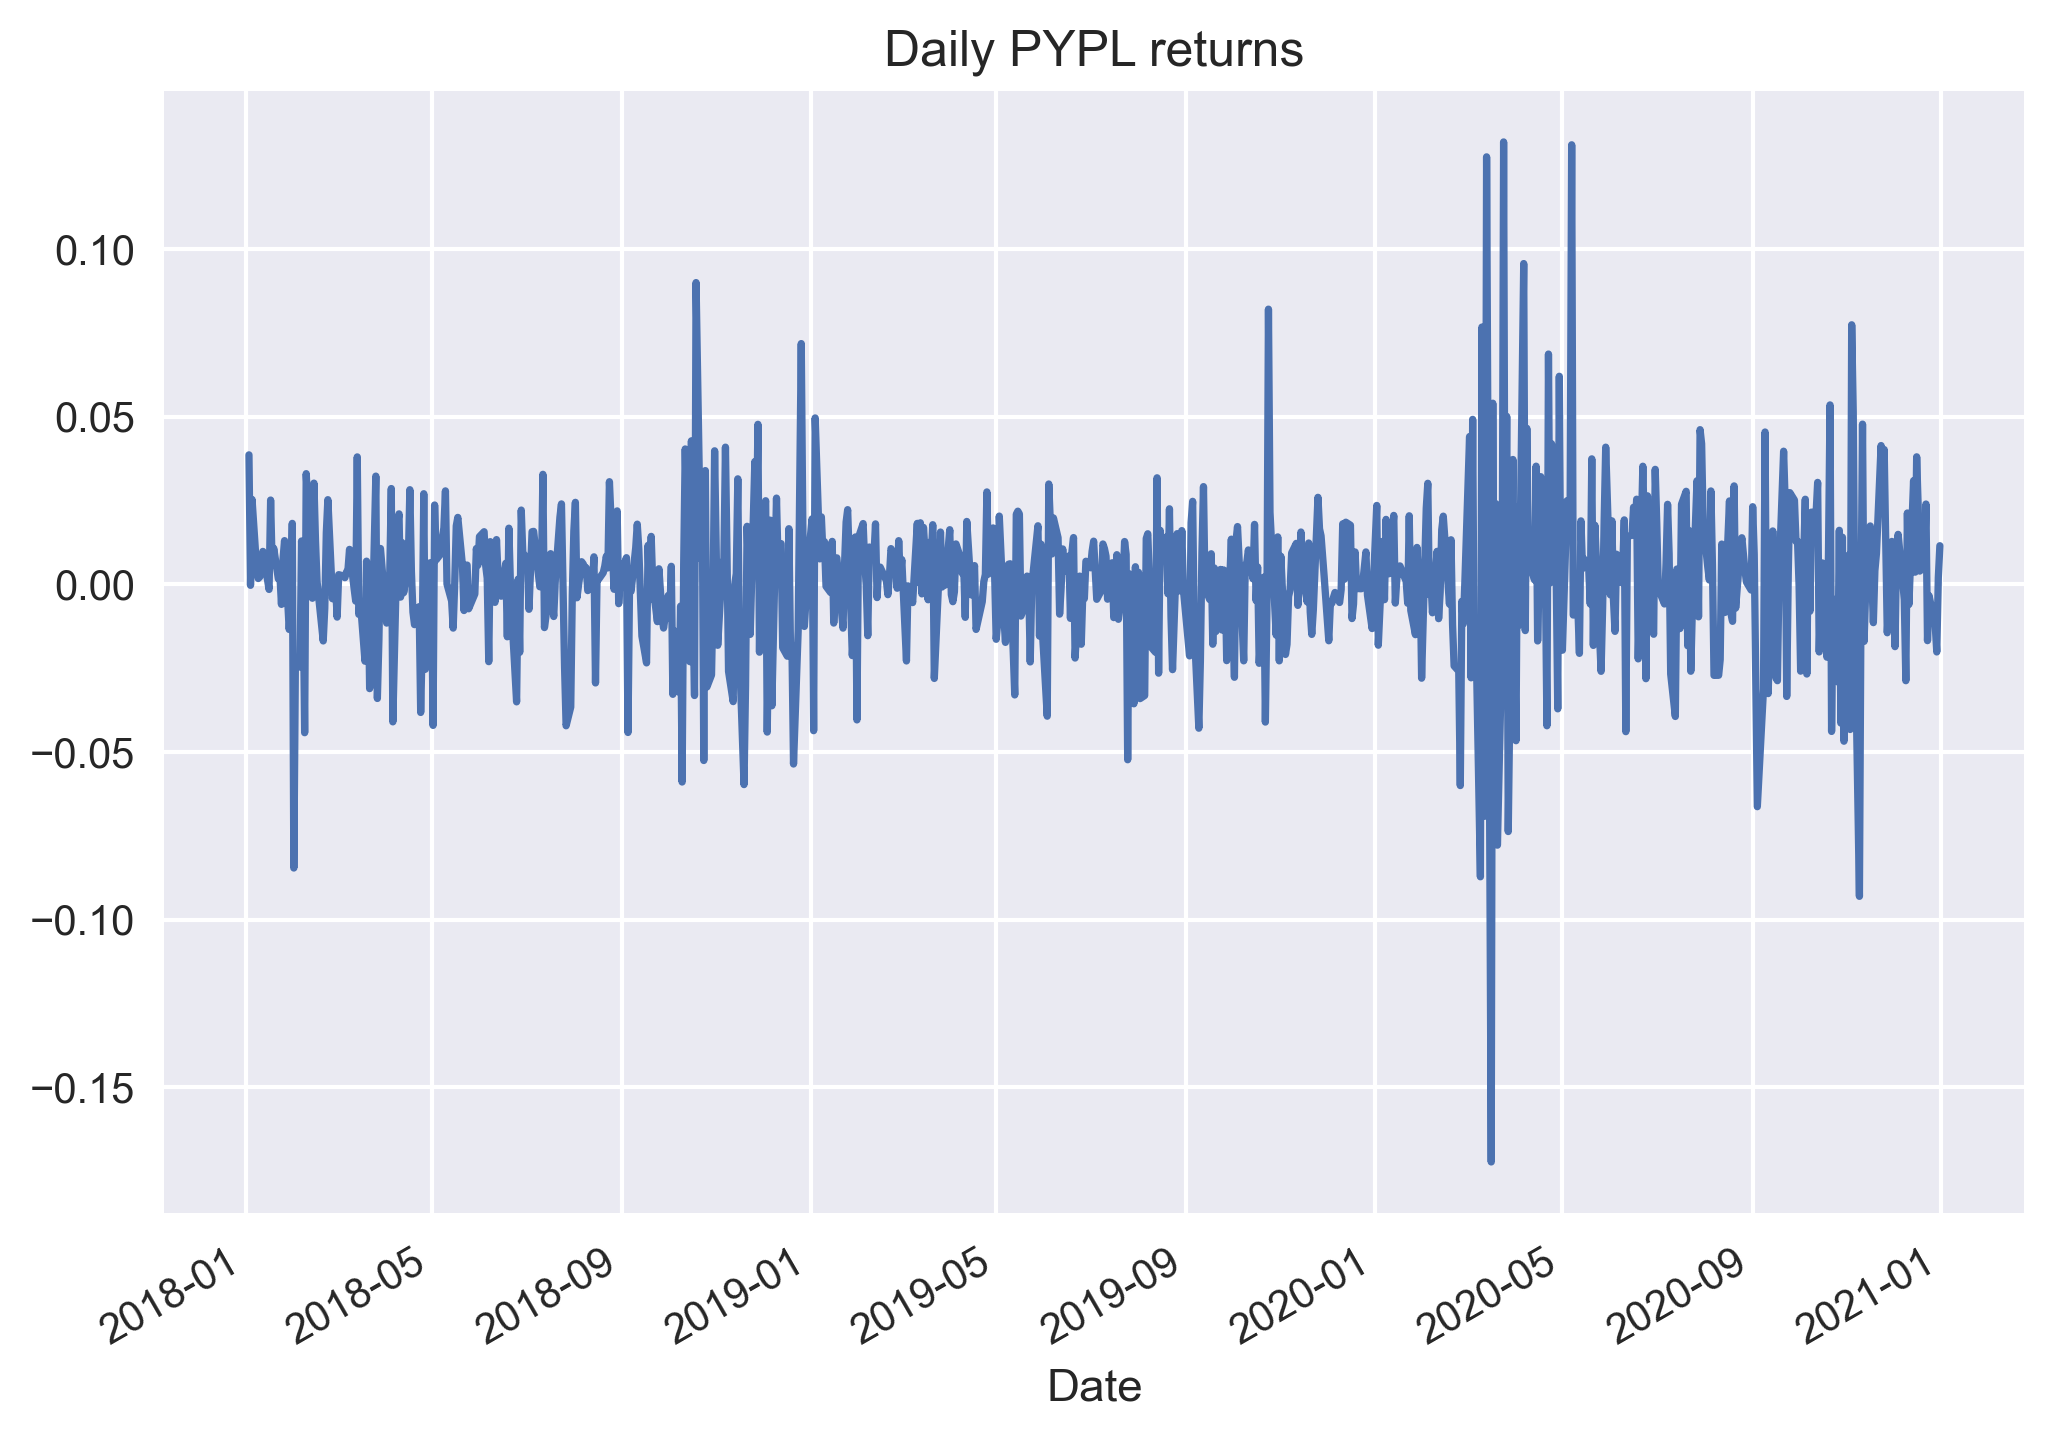

In [31]:
stock_close.log_return.plot(title=f'Daily {STOCK} returns')

In [36]:
def estimate_volatility(prices, l):
    """Create an exponential moving average model of the volatility of a stock
    price, and return the most recent (last) volatility estimate.
    
    Parameters
    ----------
    prices : pandas.Series
        A series of adjusted closing prices for a stock.
        
    l : float
        The 'lambda' parameter of the exponential moving average model. Making
        this value smaller will cause the model to weight older terms less 
        relative to more recent terms.
        
    Returns
    -------
    last_vol : float
        The last element of your exponential moving averge volatility model series.
    
    """
    # TODO: Implement the exponential moving average volatility model and return the last value.
    alpha = 1- l
    shifted = prices.shift()
    log_returns = np.log(shifted/prices)**2
    ewm = log_returns.ewm(alpha=alpha).mean()
    return ewm.iloc[-1]**0.5

estimate_volatility(stock_close.adj_close, 0.1)

0.011148525335594128